In [1]:
# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

In [83]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # convolutional layer
        self.layer1 = GraphConv(input_dims, hidden_dims)

        # Linear layer
        self.layer2 = Linear(hidden_dims, output_dims)


    def forward(self, feature_data, edge_info, edge_weights):
        # First GCN layer
        x = self.layer1(feature_data, edge_info, edge_weights)
        x = F.relu(x)
        # Second GCN layer
        x = self.layer2(x, )
        return x
    

class Enviroment():
    def __init__(self):
        # scatter 1000 points in 2d
        self.y = tensor(np.load('cell_positions_for_training.npy')).float()

        self.y_test = tensor(np.load('cell_positions_for_test.npy')).float()


        self.X = self.y[0]

        self.model = None
        self.optimizer = None

    def get_edges(self, positions=None):
        if positions is None:
            positions = self.X
        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        tree = KDTree(positions)
        dists, indices = tree.query(positions, k=10)

        indices[dists > 4.5] = -1

        # create adjacency matrix
        adj_matrix = np.zeros((100, 100))
        for i in range(100):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        return edges, edge_weights

    def set_model(self, model):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def call_model(self):
        edges, edge_weights = self.get_edges()
        return self.model(self.X, edges, edge_weights)

    def transformation(self, X, target):
        angle = np.random.rand()*2*np.pi
        X = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in X])
        target = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in target])
        
        return X, target
    
    def test(self):
        self.model.eval()
        with torch.no_grad():
            i = np.random.randint(0, len(self.y_test)-200)
            X = self.y_test[i]
            target = self.y_test[i+100]

            edges, edge_weights = env.get_edges(X)

            out = model(X, edges, edge_weights)

            loss = F.mse_loss(out, target)

            print('Test loss:', loss.item())


    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(epochs):
            loss = torch.tensor(0.0)
            for i in range(0, len(self.y)-200, 100):
                print(int(i/len(self.y)*100), end='\r')
                X = self.y[i]
                target = self.y[i+100] 

                self.X, target = self.transformation(X, target)

                self.optimizer.zero_grad()

                out = self.call_model()


                loss = F.mse_loss(out, target)

                loss.backward()
                self.optimizer.step()

            print(loss.item())

            if epoch % 5 == 0:
                self.test()


env = Enviroment()

# create a GNN model
model = CustomGNN(2, 16, 2)

env.set_model(model)

env.train(5000)

1.4601532220840454
Test loss: 1.261031150817871
1.0061306953430176
0.8275570869445801
0.576569676399231
0.45205575227737427
0.297629177570343
Test loss: 0.2539759874343872
0.2125055342912674
0.1624017208814621
0.11688871681690216
0.08239634335041046
0.09297461807727814
Test loss: 0.06380251795053482
0.05363457649946213
0.07868689298629761
0.07676197588443756
0.036151785403490067
0.02740320935845375
Test loss: 0.027382109314203262
0.026350056752562523
0.027020230889320374
0.03137192502617836
0.021625418215990067
0.014523179270327091
Test loss: 0.017490321770310402
0.013862493447959423
0.024194350466132164
0.015367954969406128
0.02479671873152256
0.010266367346048355
Test loss: 0.009072675369679928
0.012943238951265812
0.014232068322598934
0.01362622156739235
0.017703542485833168
0.019093720242381096
Test loss: 0.008346120826900005
0.016400348395109177
0.016702281311154366
0.006939383689314127
0.010679318569600582
0.008005586452782154
Test loss: 0.006253030151128769
0.018110189586877823


KeyboardInterrupt: 

In [84]:
model.train(False)

CustomGNN(
  (layer1): GraphConv(2, 16)
  (layer2): Linear(16, 2, bias=True)
)

(-1.0, 1.0)

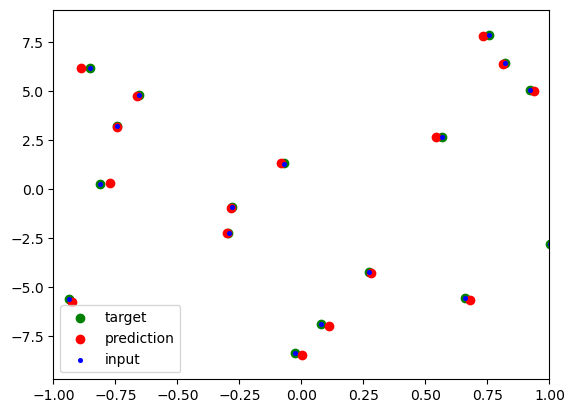

In [93]:
y = tensor(np.load('cell_positions_for_test.npy')).float()


i = 2000
y_pred = y[i+100]
X_test = y[i]

# rotate all positions 90 degrees
X_test = torch.tensor([[x[1], -x[0]] for x in X_test])
y_pred = torch.tensor([[x[1], -x[0]] for x in y_pred])

edges, edge_weights = env.get_edges(X_test)

out = model(X_test, edges, edge_weights)

plt.scatter(y_pred[:, 0], y_pred[:, 1], c='g', label='target')
plt.scatter(out[:, 0].detach().numpy(), out[:, 1].detach().numpy(), c='r', label='prediction')
plt.scatter(X_test[:, 0], X_test[:, 1], c='b', label='input', s = 7)

plt.legend()

plt.xlim(-1, 1)
